### 필요 Package download

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 현재 gpu를 사용중이면 cuda로 출력됩니다!:
# gpu 변경은 런타임 -> 런타임 유형변경 -> 하드웨어 가속기: GPU로 할 수 있습니다.

print(device)

cuda


## 데이터 부연설명
* 저희가 사용할 dataset은 cifar-10이라는 이름을 가진, 컬러 이미지 데이터 60,000개가 들어있는
dataset입니다. <br>
* 해당 dataset은 총 10개의 class로 나누어져 있으며, 이 task는 각 이미지에 대한 image classification의 accuracy를 높이는 것이 목적입니다.

### Data Normalize & DataLoader Settting

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:04<00:00, 37165603.91it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


  car  frog truck truck


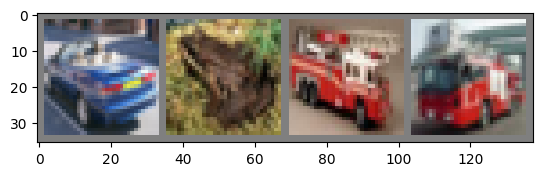

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.__next__()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

In [5]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5) # input channels, output channels, kernel size
        self.pool = nn.MaxPool2d(2, 2)  # kernel size, stride, padding = 0 (default)
        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16 * 5 * 5, 120)   # input features, output features
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 48)   # Adding a new fully connected layer
        self.fc4 = nn.Linear(48, 24)   # Adding another fully connected layer
        self.fc5 = nn.Linear(24, 10)   # Output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))  # Applying ReLU activation to the new fully connected layer
        x = F.relu(self.fc4(x))  # Applying ReLU activation to the second new fully connected layer
        x = self.fc5(x)          # No ReLU activation for the output layer
        return x


net = Net()

In [17]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

#optimizer를 변경하거나 수치를 조정해보는 것도 accuracy를 높이는 데 도움을 줄 수 있습니다!
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(net.parameters(), lr=0.0001)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce the learning rate by half every 5 epochs

In [18]:
for epoch in range(1):  # 데이터셋을 n차례 반복하여 학습합니다. 또한 range 속의 숫자도 바꾸어 학습률을 높이는 것도 도움이 될 겁니다!

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # 입력을 받은 후
        inputs, labels = data
        # 변화도(Gradient) 매개변수를 0으로 만든 후
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계 출력

        running_loss += loss.item()
        # 2000개의 data를 학습할때마다 loss 출력
        if i % 2000 == 1999:    # % 뒤에 들어갈 숫자의 크기를 조정하여 batch_size를 조정할 수 있습니다! 그리고 i % n == n-1:로 숫자를 맞춰주셔야 한다는 점 잊지 마세요!
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000)) # running_loss 우측의 숫자 역시 윗줄에서 바꾼 batch_size로 바꿔주어야 합니다!
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 1.268
[1,  4000] loss: 1.240
[1,  6000] loss: 1.219
[1,  8000] loss: 1.207
[1, 10000] loss: 1.197
[1, 12000] loss: 1.217
Finished Training


GroundTruth:    cat  ship  ship plane


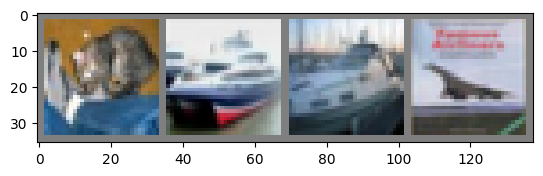

In [19]:
dataiter = iter(testloader)
images, labels = dataiter.__next__()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
plt.show()

In [20]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    cat  ship plane plane


In [21]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 55 %


In [22]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 63 %
Accuracy of   car : 69 %
Accuracy of  bird : 35 %
Accuracy of   cat : 33 %
Accuracy of  deer : 45 %
Accuracy of   dog : 45 %
Accuracy of  frog : 67 %
Accuracy of horse : 62 %
Accuracy of  ship : 66 %
Accuracy of truck : 62 %


출처: https://m.blog.naver.com/ckdgus1433/221406102936의 튜토리얼을 참고하였습니다!

#과제

##1. 실습 파일의 overfitting model의 optimizer, epoch, learning rate 등을 변경하여 실행한 결과와, underfitting의 layer를 2개 이상 추가하여 실행한 결과를 각각 캡처하여 overfit, underfit이라는 이름으로 깃허브에 제출하기.  <br> <br>

##2. 과제 파일을 수정하여 Test image에 대한 accuracy를 56% 이상으로 높이고, 모델의 결과에 대한 캡처본과 파일을 모두 깃허브에 제출하기. <br>
Hint: 파일 중간중간에 설명이 있는 부분을 참고하시면 아마 될 겁니다!<br>
(layer 추가, optimizer 변경, learning rate 조정 등...) <br>

##3. MLP model과 기존 ML model의 차이점을 최소 2가지 측면에서 서술하기. <br>
1. MLP model은 fully connected multi-layer neural network이다. MLP model은 모델의 결과를 설명하기 어려운 반면, ML model은 간명하게 설명 가능하다.

2. ML model은 새로운 데이터가 유입되며 특정 기능을 수행하는 데 점점 더 능숙해지지만, 여전히 인간의 개입이 필요하다. 즉, AI 알고리즘이 부정확한 예측을 반환하면 엔지니어가 개입하여 조정해야한다. 하지만 MLP model은 알고리즘이 자체적인 인공신경망을 통해 예측의 정확성 여부를 스스로 판단할 수 있어 인간의 도움이 필요하지 않다. 즉, ML model은 특성 공학이 필요한 반면, MLP model은 특성 공학이 필요하지 않다.

3. 보통 ML model은 CPU로 수행되는 반면, MLP model은 그 복잡성으로 인해 GPU로 수행된다.

## 출처
- https://www.geeksforgeeks.org/difference-between-machine-learning-and-deep-learning/
- https://www.simplilearn.com/tutorials/deep-learning-tutorial/multilayer-perceptron

